In [2]:
%matplotlib inline

#import ROOT
#from ROOT import TCanvas, TH1F, TLegend
from NNDefs import build_and_train_class_nn
from LayersDefs import get_signal_and_background_frames, calculate_derived_et_columns, roc_efficiencies, background_eff_at_target_signal_eff
#from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from tqdm import tqdm

Welcome to JupyROOT 6.14/02


In [32]:
signal_frame, background_frame = get_signal_and_background_frames()

calculate_derived_et_columns(signal_frame, background_frame)

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1, 1, 1], column_names=['L0Et', 'L1Et', 'L2Et', 'L3Et'],
                                     output_column_name='EmEt')

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L0Et', 'L1Et'],
                             output_column_name='L0+L1Et')

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L2Et', 'L3Et'],
                             output_column_name='L2+L3Et')

# Calculate 3 layer with minimum weights
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1.3, 8.4], column_names=['L0+L1Et', 'L2+L3Et', 'HadEt'],
                             output_column_name='3LayerWeightedEt')

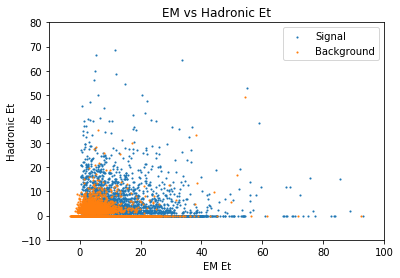

In [47]:
plt.scatter(signal_frame[['EmEt']].values, signal_frame[['HadEt']].values, 1.2, label='Signal')
plt.scatter(background_frame[['EmEt']].values, background_frame[['HadEt']].values, 1.2, label='Background')
plt.title('EM vs Hadronic Et')
plt.xlabel('EM Et')
plt.xlim(-10, 100)
plt.ylabel('Hadronic Et')
plt.ylim(-10, 80)
plt.legend(loc='upper right')
plt.show()

In [18]:
em_sig_frac = signal_frame['EmEt'] / signal_frame['TotalEt']
had_sig_frac = signal_frame['HadEt'] / signal_frame['TotalEt']
print('Fraction of EM energy in signal events:')
print(em_sig_frac.mean(axis=0))
print('Fraction of hadronic energy in signal events:')
print(had_sig_frac.mean(axis=0))

em_back_frac = background_frame['EmEt'] / background_frame['TotalEt']
had_back_frac = background_frame['HadEt'] / background_frame['TotalEt']
print('Fraction of EM energy in background events:')
print(em_back_frac.mean(axis=0))
print('Fraction of hadronic energy in background events:')
print(had_back_frac.mean(axis=0))

Fraction of EM energy in signal events:
0.8289195041678167
Fraction of hadronic energy in signal events:
0.17108049583218327
Fraction of EM energy in background events:
0.9791037821390038
Fraction of hadronic energy in background events:
0.02089621786099614


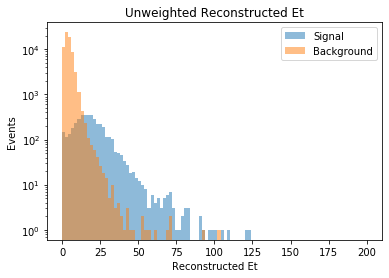

In [46]:
plt.hist(signal_frame['TotalEt'], 100, (0,200), log=True, alpha=0.5, label='Signal')
plt.hist(background_frame['TotalEt'], 100, (0, 200), alpha=0.5, label='Background')
plt.title('Unweighted Reconstructed Et')
plt.xlabel('Reconstructed Et')
plt.ylabel('Events')
plt.legend(loc='upper right')
plt.show()

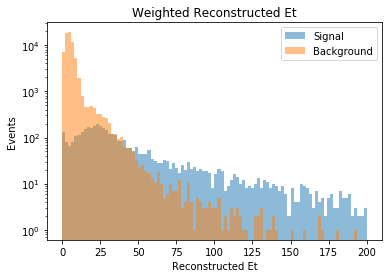

In [45]:
plt.hist(signal_frame['3LayerWeightedEt'], 100, (0,200), log=True, alpha=0.5, label='Signal')
plt.hist(background_frame['3LayerWeightedEt'], 100, (0, 200), alpha=0.5, label='Background')
plt.title('Weighted Reconstructed Et')
plt.xlabel('Reconstructed Et')
plt.ylabel('Events')
plt.legend(loc='upper right')
plt.show()

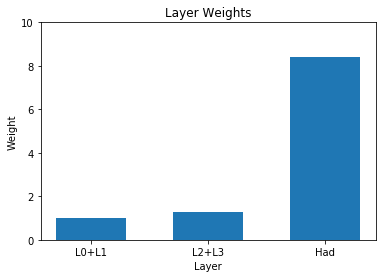

In [9]:
weights = [1, 1.3, 8.4]
ticks = [.5, 1, 1.5]
plt.bar(ticks, weights, 0.3)
plt.xticks(ticks, ('L0+L1', 'L2+L3', 'Had'))
plt.title('Layer Weights')
plt.xlabel('Layer')
plt.ylabel('Weight')
plt.ylim(0,10)
plt.show()